<a href="https://colab.research.google.com/github/nicolasyannick/wine-quality-pca-mlr/blob/main/Wine_Quality_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
#Load the important libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import boxcox

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


<h3>Importing the Wine Quality Dataset<h3>

In [3]:
df = pd.read_csv('/content/drive/MyDrive/WineQT.csv')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9.8        5   2  
3      9.8        6   3  
4      9.4        5   4

## Preparation of the Dataset

In [4]:
# Converting the Quality in a binary class
# if 0 < quality <= 5 : 0
# if 5 < quality <= 10 : 1


threshold = 5
df['quality_class'] = (df['quality']>threshold).astype(int)


# Drop the "Id" and "quality" columns
df.drop(columns=['Id','quality'], inplace=True)


In [5]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality_class  
0      9.4              0  
1      9.8              0  
2      9.8              0  
3      9.8              1  
4      9.4              0

## Dataset Imbalance

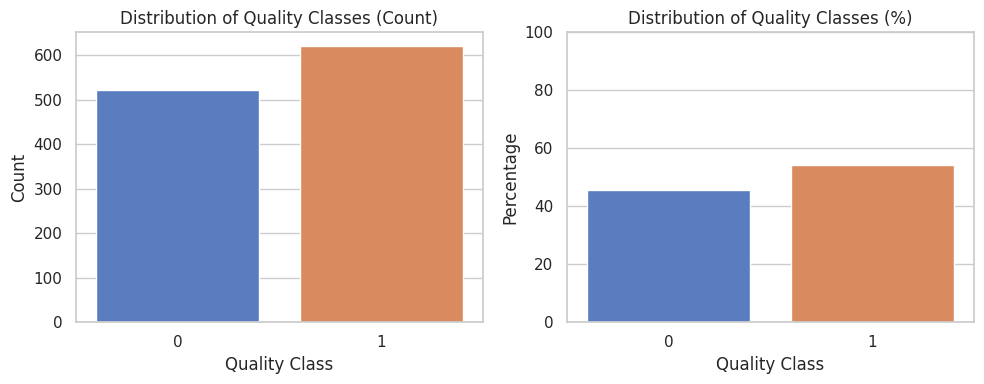

In [6]:
sns.set(style='whitegrid')

quality_class_count = df['quality_class'].value_counts()
quality_class_percentage = df['quality_class'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.countplot(data=df, x='quality_class', palette='muted', ax=axes[0])
axes[0].set_title('Distribution of Quality Classes (Count)')
axes[0].set_xlabel('Quality Class')
axes[0].set_ylabel('Count')

sns.barplot(x=quality_class_percentage.index, y=quality_class_percentage.values, palette='muted', ax=axes[1])
axes[1].set_title('Distribution of Quality Classes (%)')
axes[1].set_xlabel('Quality Class')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

## Feature Correlation

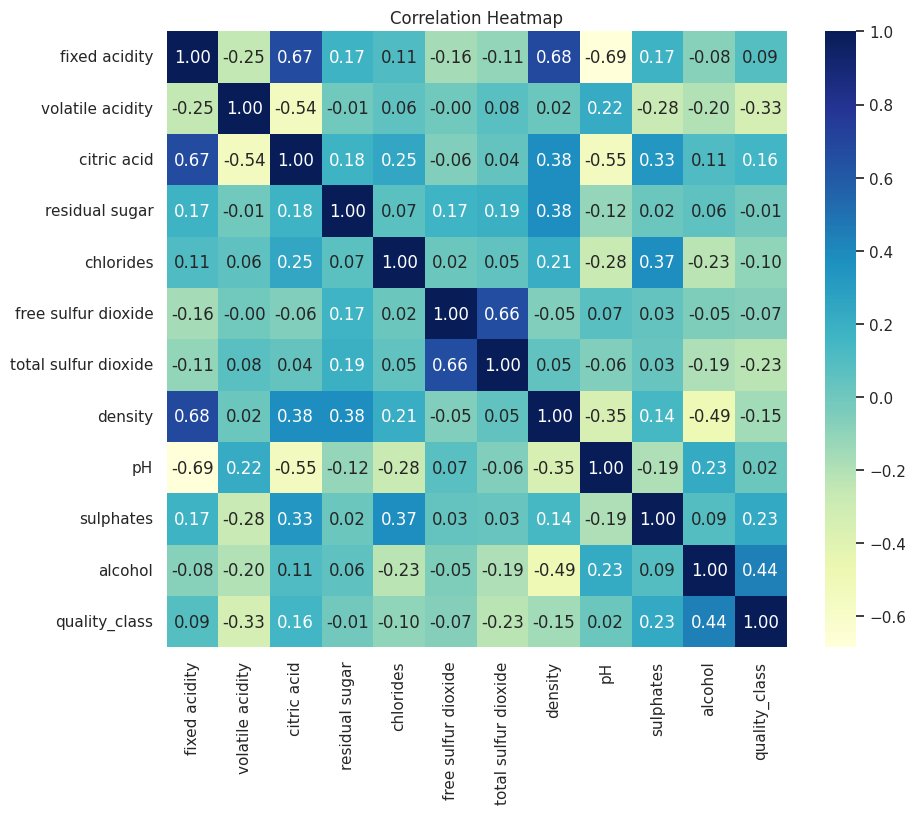

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation Heatmap')
plt.show()

## Distribution Plots

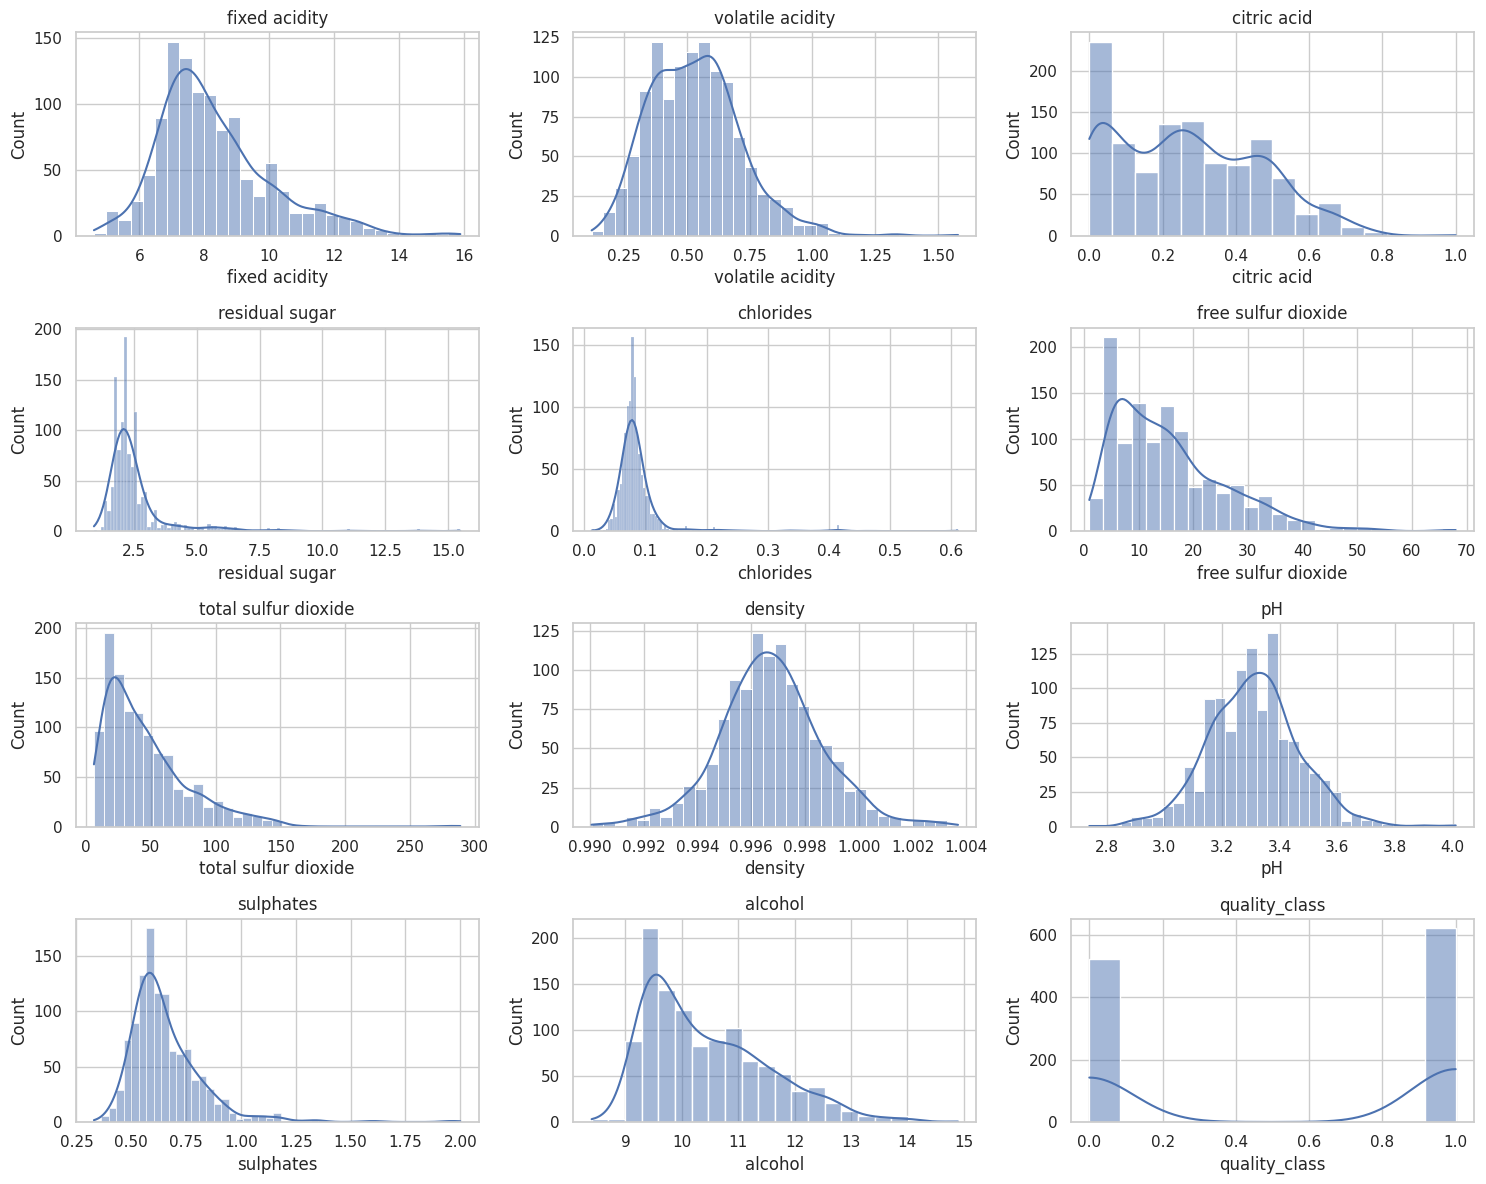

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(column)

plt.tight_layout()

plt.show()

## Pairplots

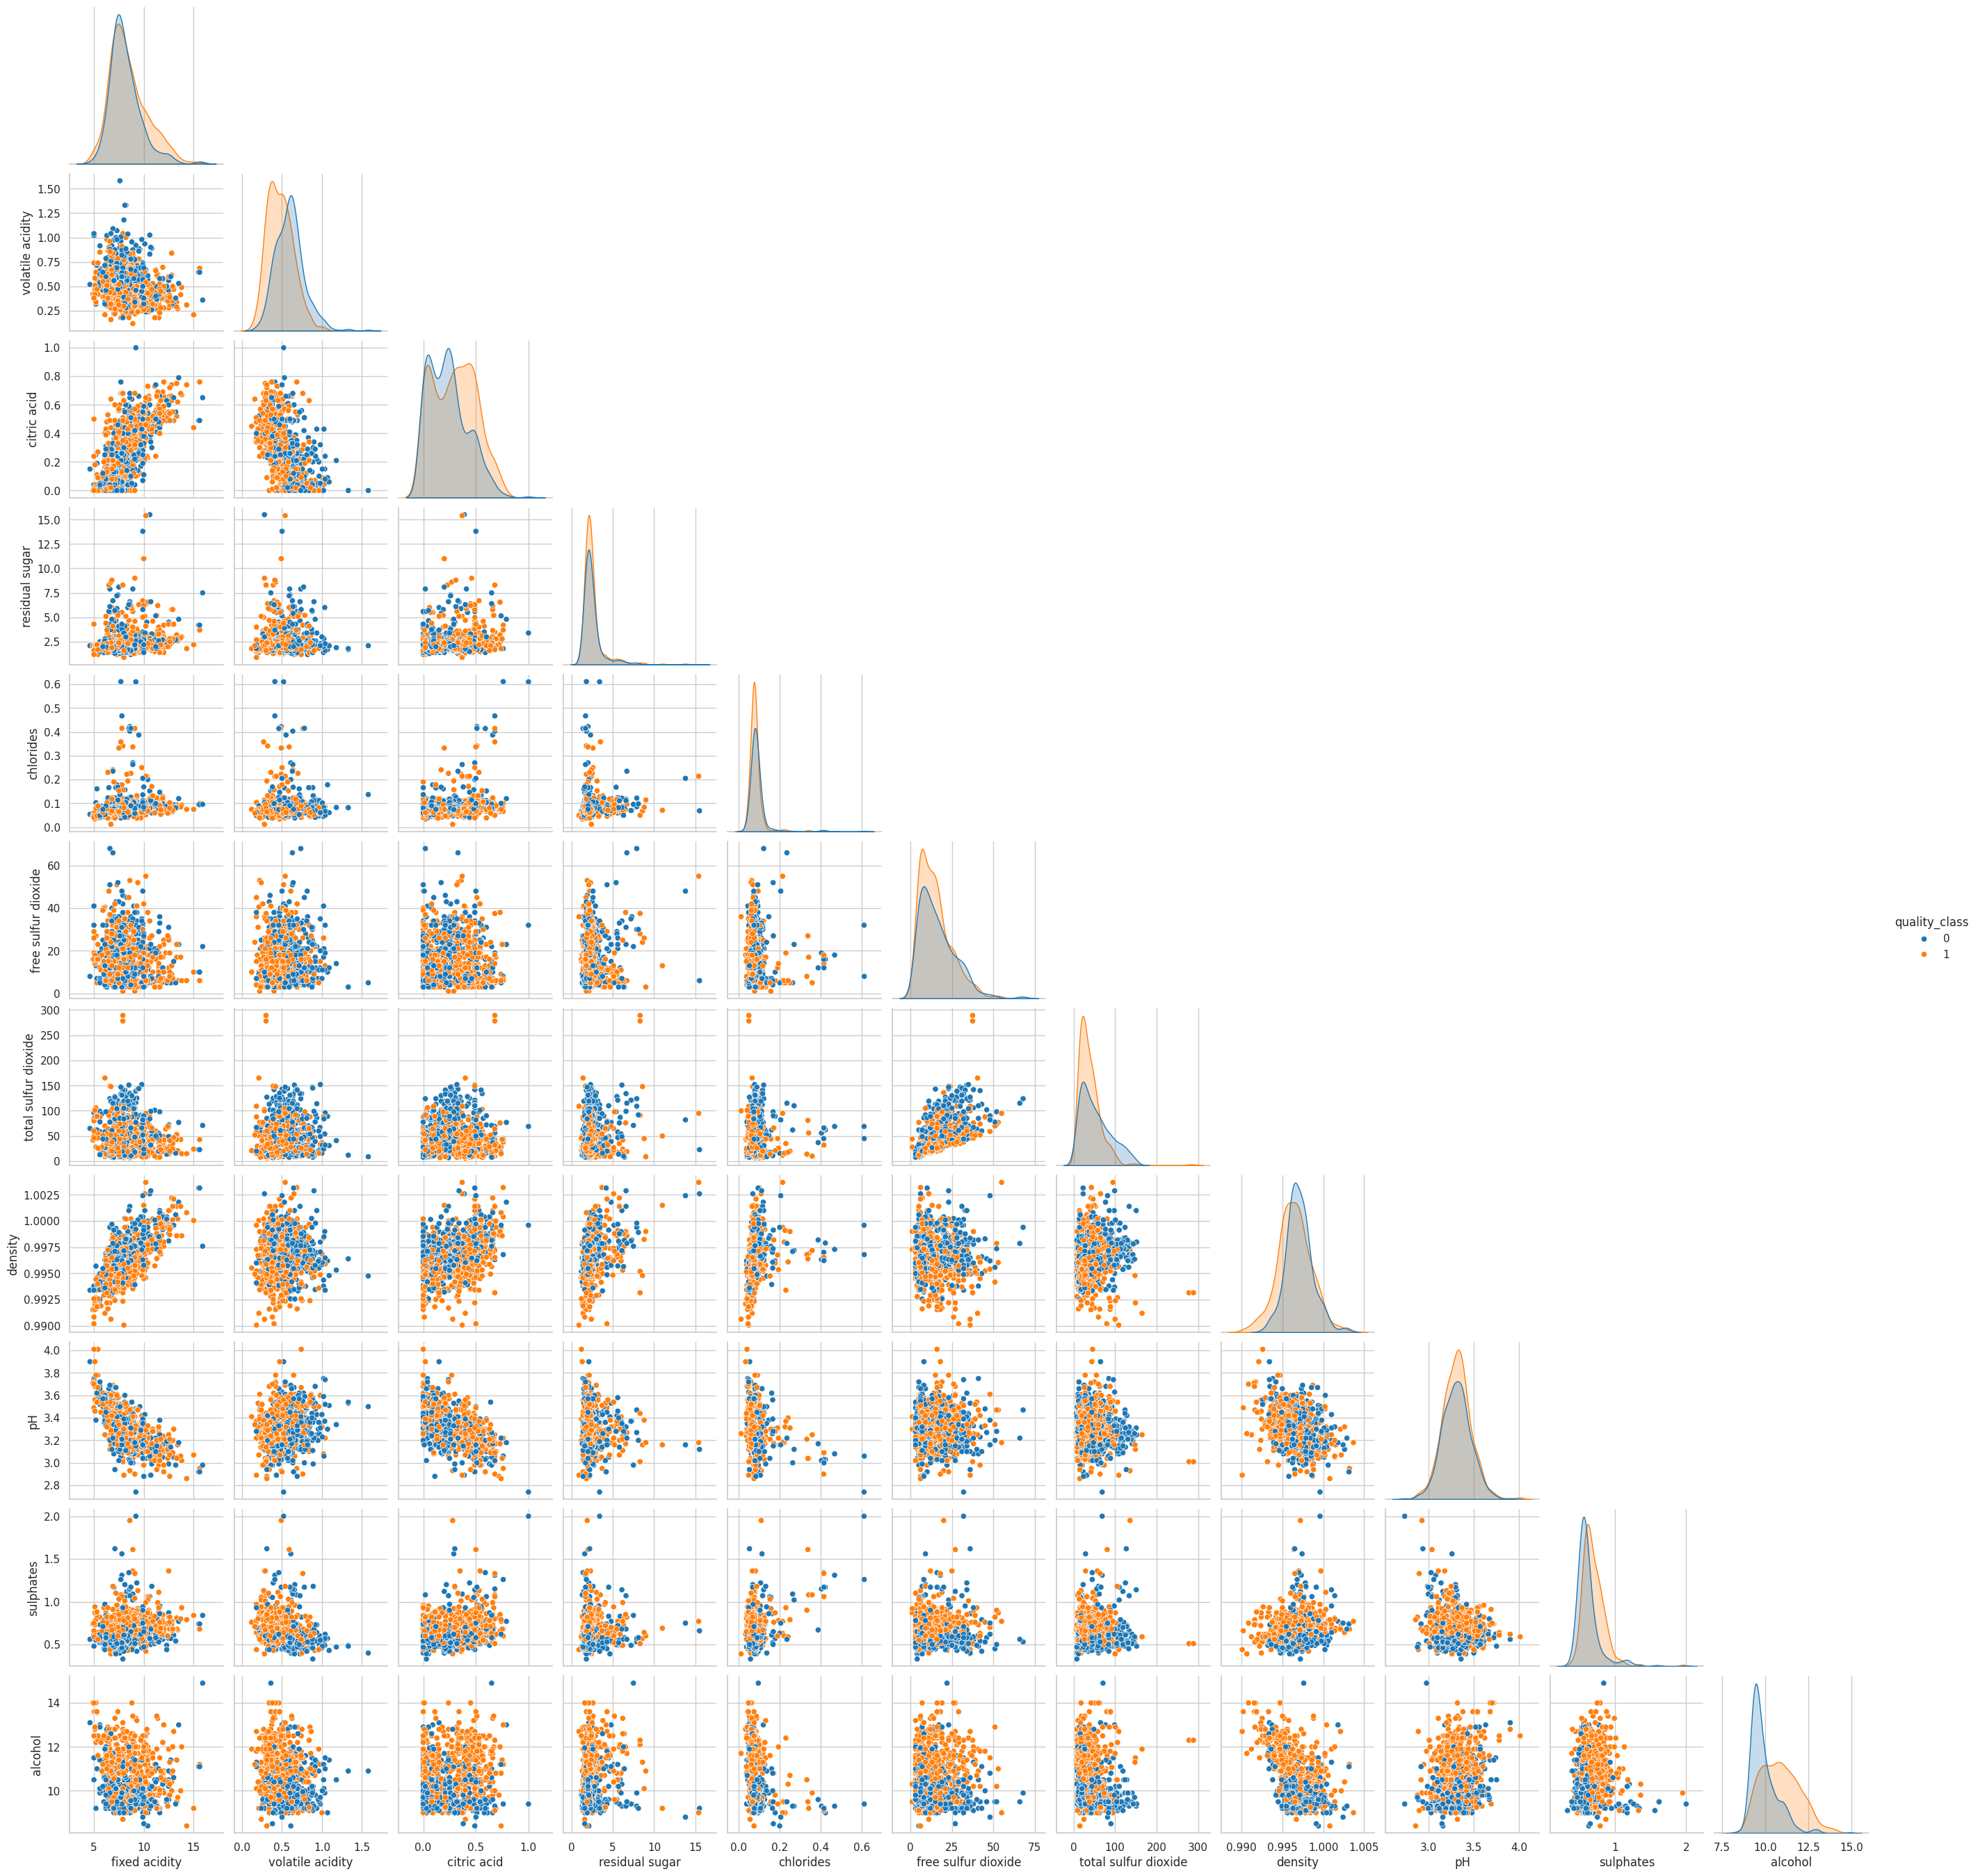

In [9]:
sns.pairplot(df, hue='quality_class', corner=True, palette="tab10")
plt.show()

In [10]:
# Define a function to apply Box-Cox transformation to a single column
def apply_boxcox(column):
    transformed_column, _ = boxcox(column + 1)  # Adding 1 to handle zero values
    return transformed_column

# Apply Box-Cox transformation to all columns except the last one
df_boxcox_transformed = df.iloc[:, :-1].apply(apply_boxcox, axis=0)

# Convert the transformed data back to a DataFrame
df_boxcox_transformed = pd.DataFrame(df_boxcox_transformed, columns=df.columns[:-1])

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(df_boxcox_transformed)

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(X_normalized, columns=df_boxcox_transformed.columns)


# Concatenate the transformed DataFrame with the last column (target variable)
df_normalized['quality_class'] = df['quality_class']

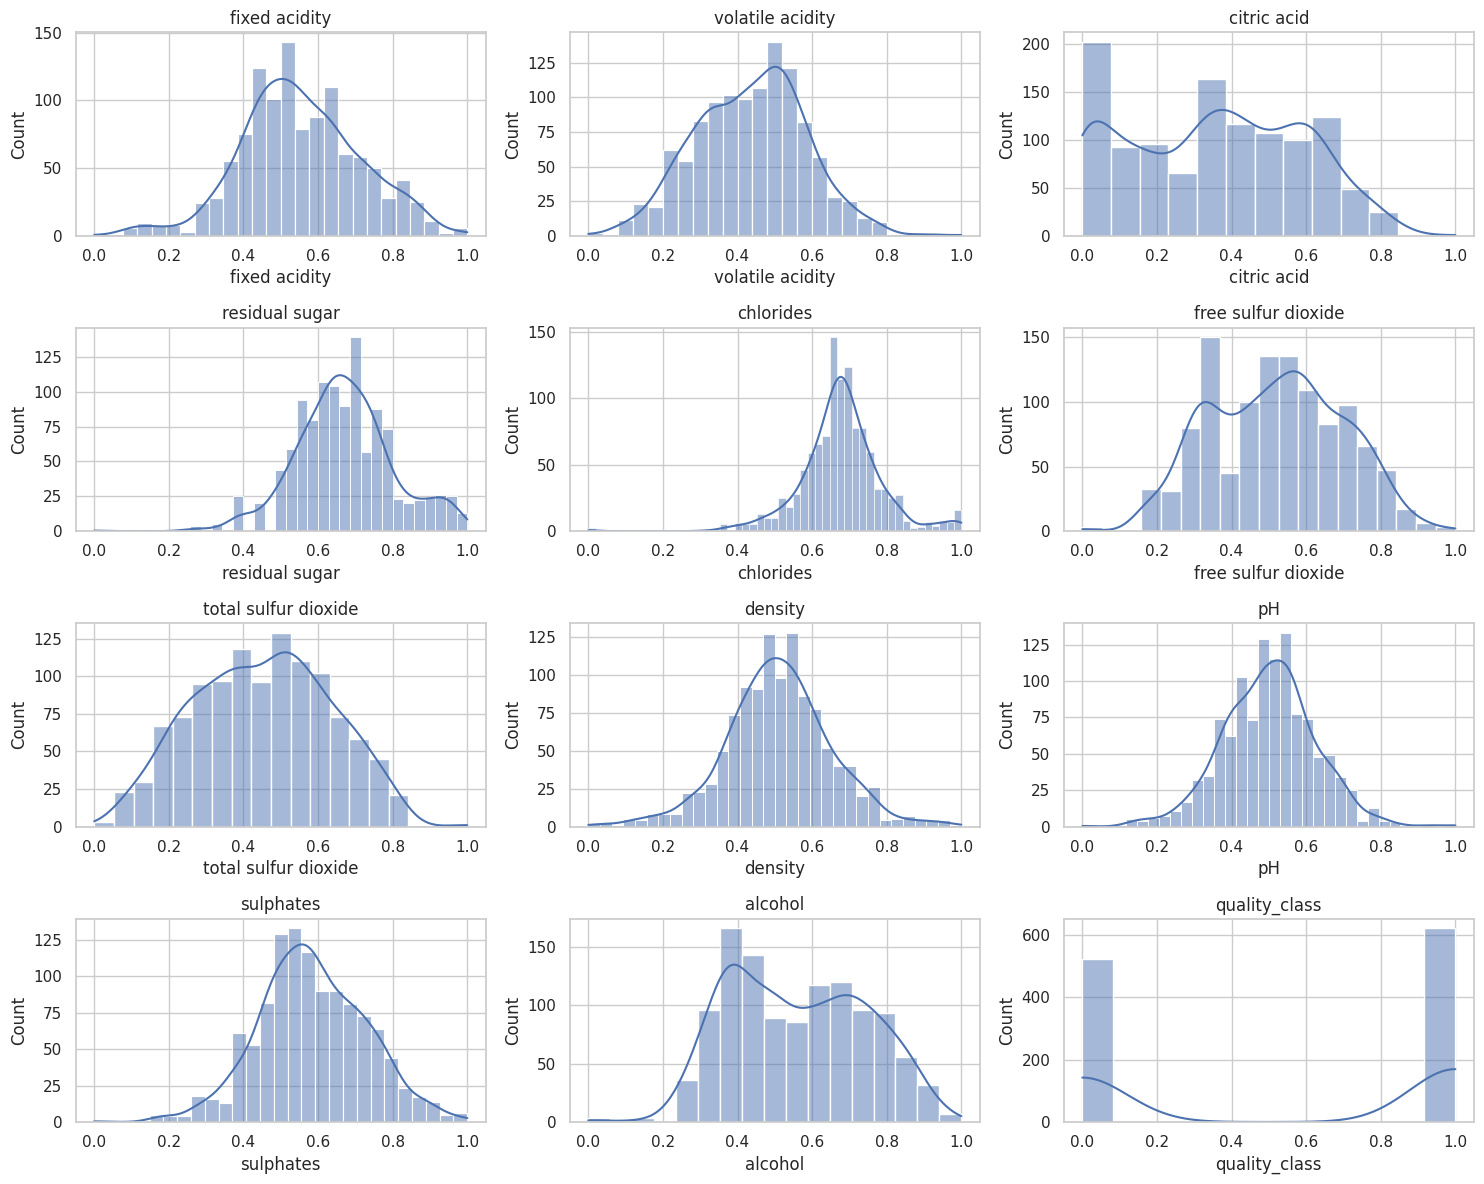

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df_normalized[column], kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(column)

plt.tight_layout()

plt.show()

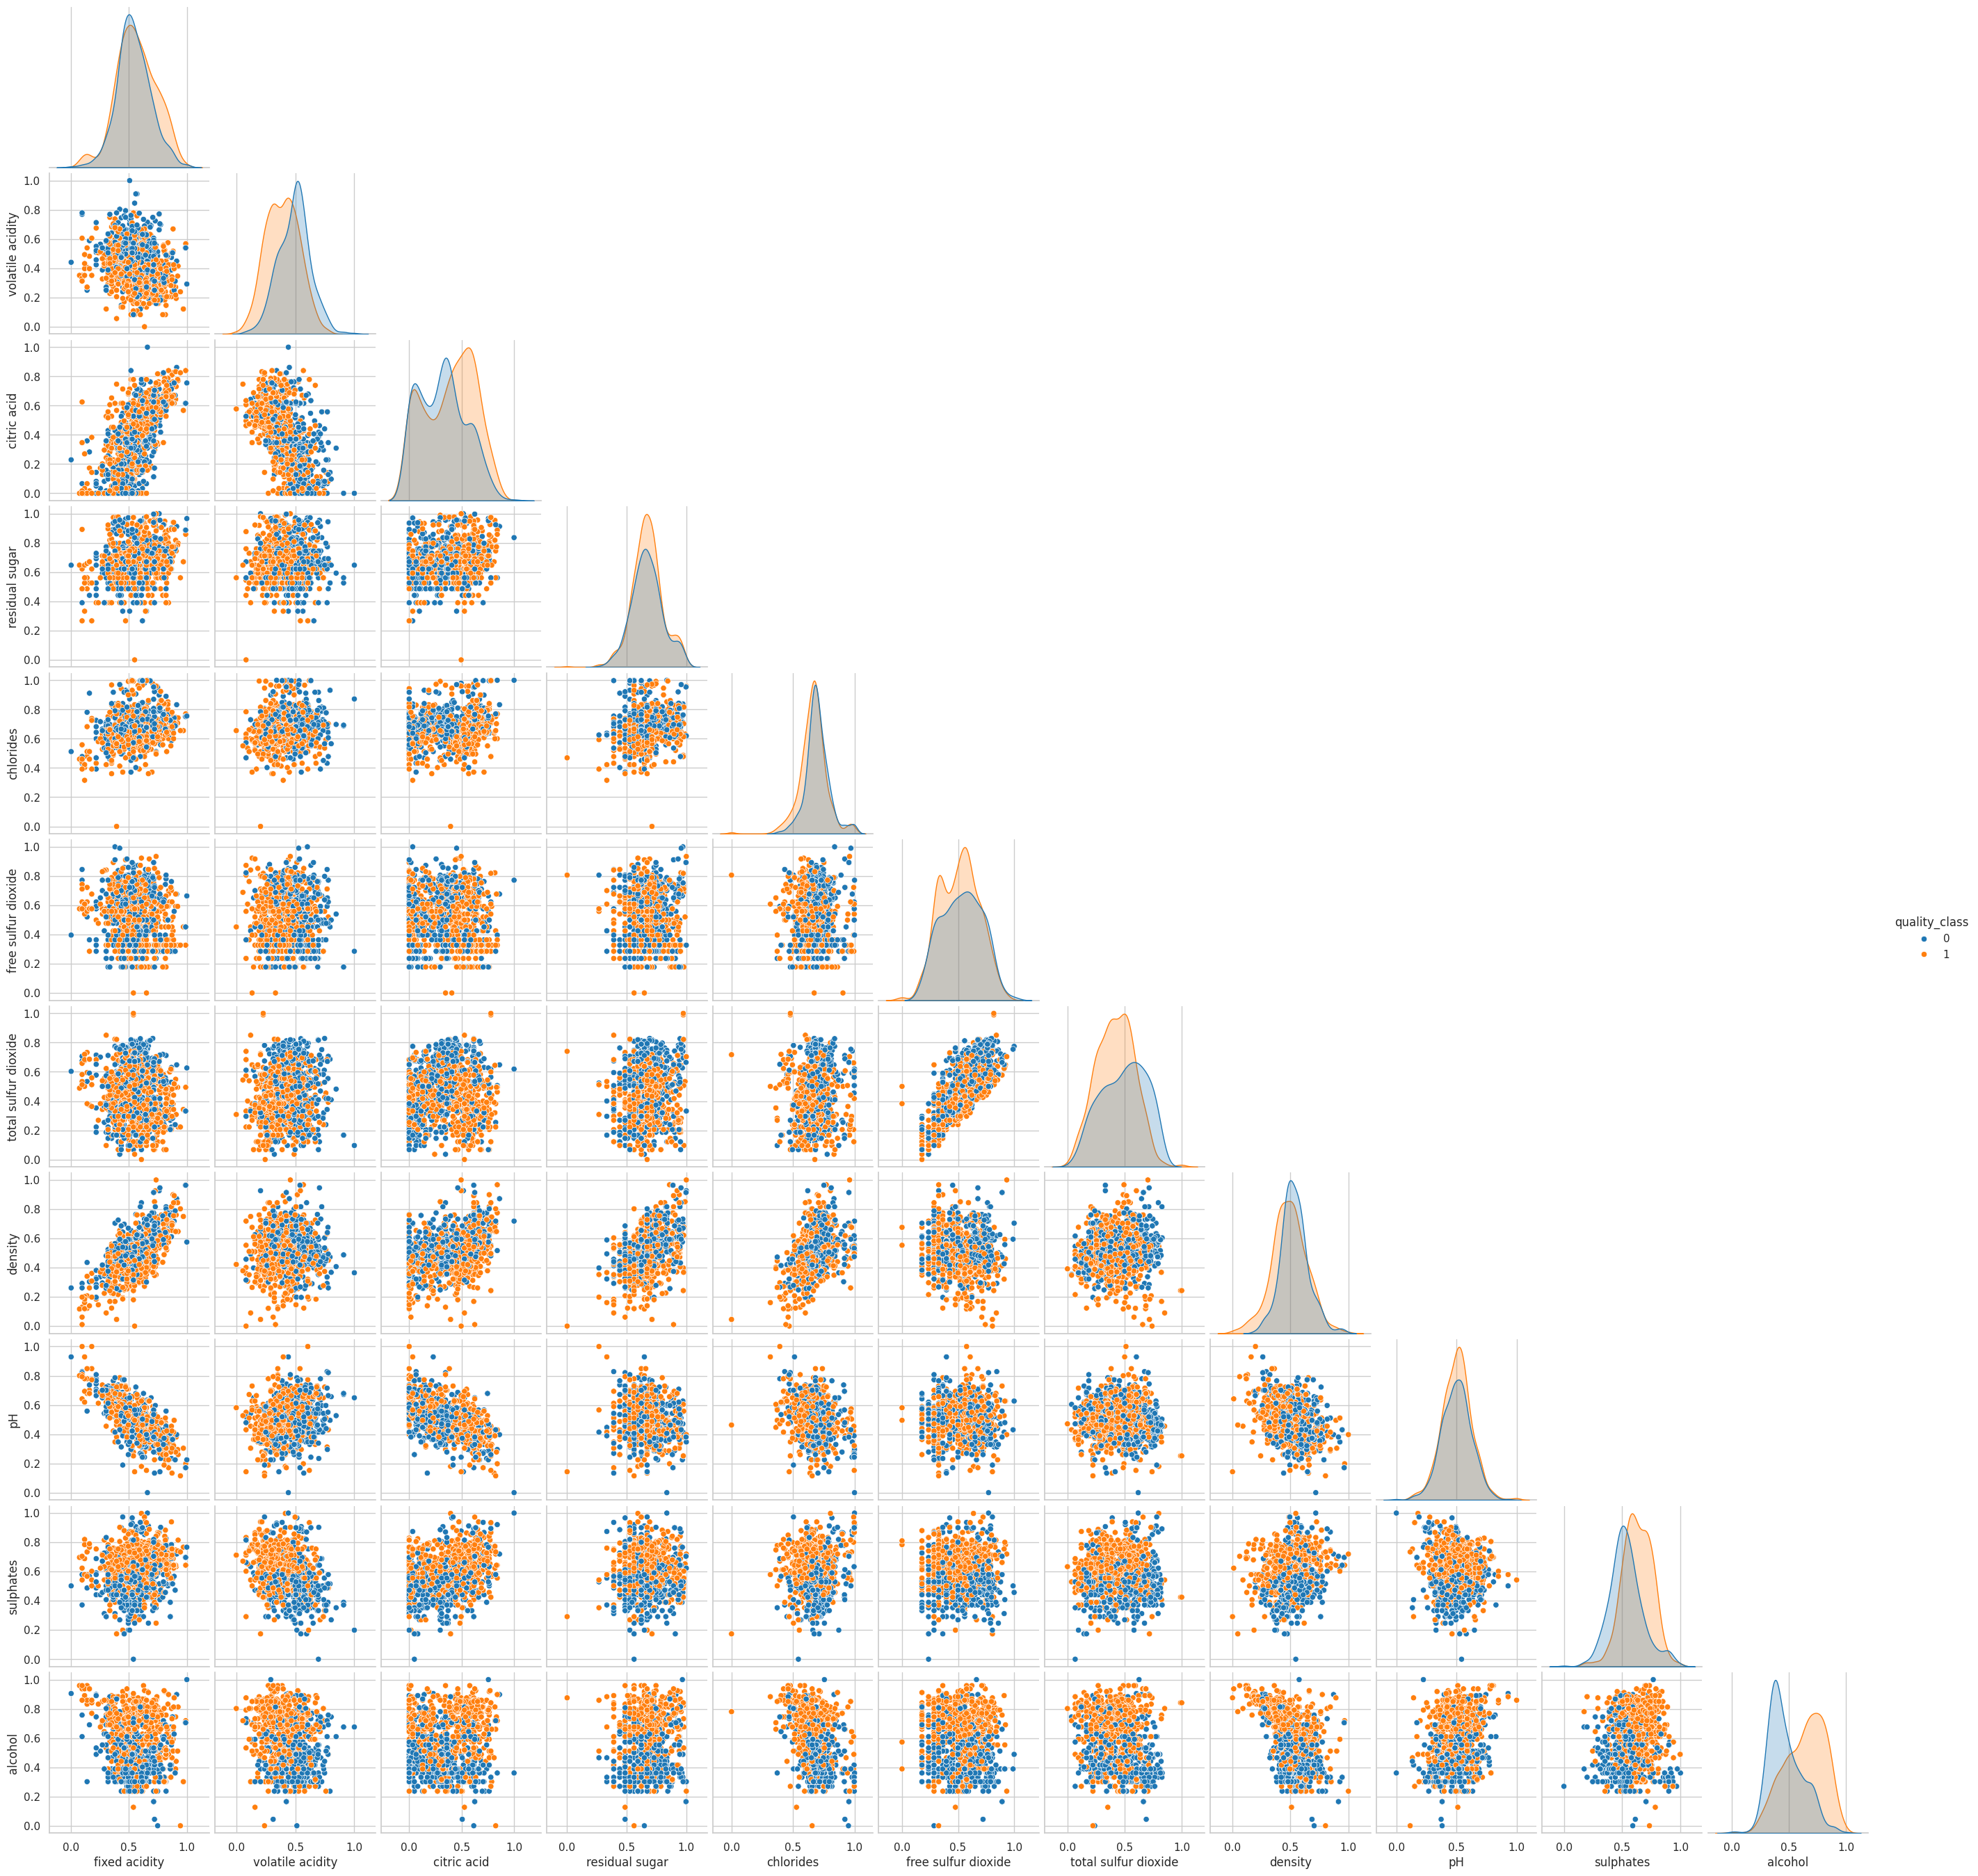

In [12]:
sns.pairplot(df_normalized, hue='quality_class', corner=True, palette="tab10")
plt.show()

## Covariance Matrix

In [24]:
covariance_matrix = np.cov(df_normalized, rowvar=False)

## Eigen Values / Eigen Vectors

In [14]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

In [15]:
order_of_importance = np.argsort(eigenvalues)[::-1]

sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors =  eigenvectors[:,order_of_importance]

In [16]:
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

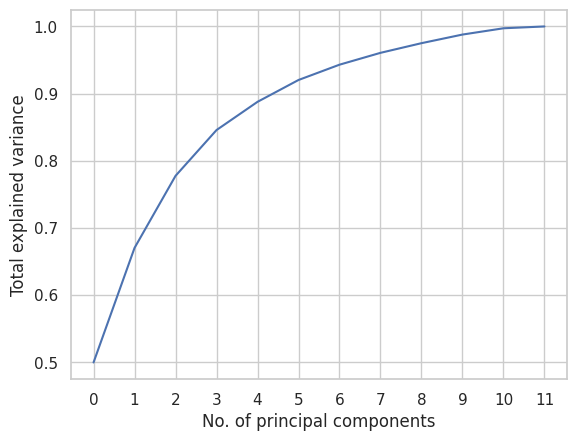

In [17]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel('No. of principal components')
plt.ylabel('Total explained variance')
plt.xticks(np.arange(0, len(explained_variance), 1))

plt.show()

In [18]:
print(order_of_importance)

[ 0  1  2  3  4  5  7  9 11 10  8  6]


In [19]:
df_normalized.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.482507          0.578705     0.000000        0.593469   0.661033   
1       0.527663          0.692887     0.000000        0.745355   0.762859   
2       0.527663          0.619047     0.065907        0.692337   0.738775   
3       0.797733          0.205492     0.679168        0.593469   0.655425   
4       0.482507          0.578705     0.000000        0.593469   0.661033   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.476458              0.432982  0.589515  0.656617   0.501712   
1             0.700349              0.611304  0.516601  0.413864   0.643132   
2             0.558413              0.554359  0.531261  0.462890   0.612644   
3             0.592425              0.582151  0.603982  0.380598   0.529223   
4             0.476458              0.432982  0.589515  0.656617   0.501712   

    alcohol  quality_class  
0  0.361148              0  
1  0.465365              0  
2  0.465365              0  
3  0.465365              1  
4  0.361148              0

In [20]:
print(explained_variance)

[0.49969771 0.17056189 0.10727599 0.06819273 0.04202696 0.03251655
 0.02278799 0.01765335 0.01437913 0.01283372 0.00935096 0.00272301]


## Test - Train Split

In [23]:
X = df_normalized.iloc[:,:-1]
Y = df_normalized.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

## Logistic Regression using 5 Principal Components

In [41]:
num_components = 5
columns_to_keep = X_train.columns[order_of_importance[:num_components]]
X_train_pca = X_train[columns_to_keep]
X_test_pca = X_test[columns_to_keep]

In [52]:
mlr_model = LogisticRegression()
mlr_model.fit(X_train_pca, Y_train)

y_train_pred = mlr_model.predict(X_train_pca)
y_pred = mlr_model.predict(X_test_pca)

train_accuracy = accuracy_score(Y_train, y_train_pred)
test_accuracy = accuracy_score(Y_test, y_pred)
classification_rep = classification_report(Y_test, y_pred)

print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)
print("Classification report:\n", classification_rep)

Train accuracy:  0.650984682713348
Test accuracy:  0.6157205240174672
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.53      0.55       102
           1       0.64      0.69      0.66       127

    accuracy                           0.62       229
   macro avg       0.61      0.61      0.61       229
weighted avg       0.61      0.62      0.61       229



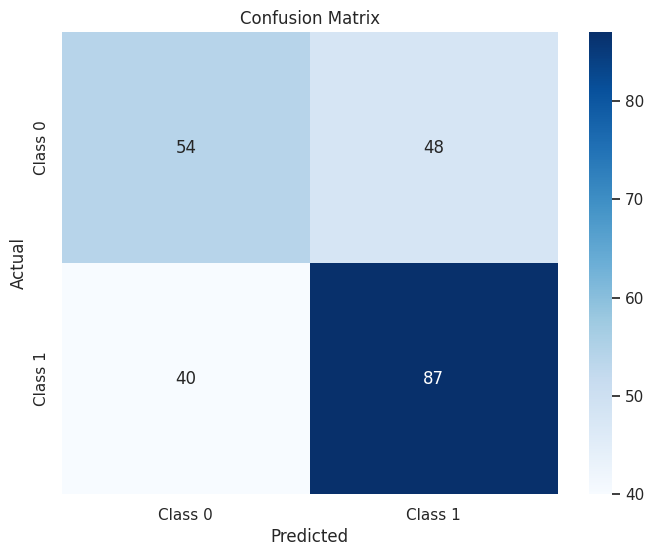

In [49]:
conf_matrix = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression using all Features

In [53]:
mlr_model = LogisticRegression()
mlr_model.fit(X_train, Y_train)

y_train_pred = mlr_model.predict(X_train)
y_pred = mlr_model.predict(X_test)


train_accuracy = accuracy_score(Y_train, y_train_pred)
test_accuracy = accuracy_score(Y_test, y_pred)
classification_rep = classification_report(Y_test, y_pred)

print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)
print("Classification report:\n", classification_rep)

Train accuracy:  0.762582056892779
Test accuracy:  0.74235807860262
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       102
           1       0.77      0.76      0.77       127

    accuracy                           0.74       229
   macro avg       0.74      0.74      0.74       229
weighted avg       0.74      0.74      0.74       229



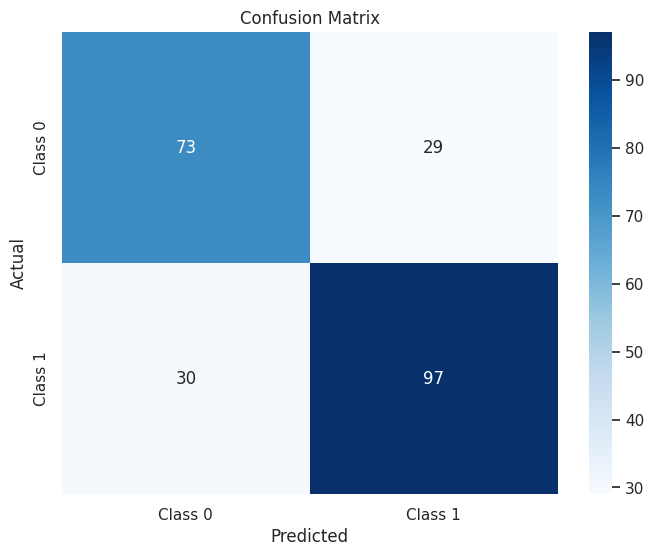

In [51]:
conf_matrix = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()